Import and helpers functions
---
- `get_driving_log` reads the csv that contains all the image names and steering angles
- `generator` is a function that creates the image generator (used for both training and validation sets)

In [1]:
import csv
import cv2
import numpy as np
import sklearn
import random

In [2]:
def get_driving_log(path):
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines

In [3]:
def generator(path, samples, batch_size=128, shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = sklearn.utils.shuffle(samples)
            
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_nb in [0, 1, 2]:
                    name = path + 'IMG/'+ batch_sample[image_nb].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    shift_dict = {0: 0, 1: 0.3, 2: -0.3} 
                    angle = float(batch_sample[3]) + shift_dict.get(image_nb, "error")
    
                    images.append(image)            
                    angles.append(angle)
                    
                    images.append(np.fliplr(image))
                    angles.append(-angle)            

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
                        
            yield sklearn.utils.shuffle(X_train, y_train) if shuffle else (X_train, y_train)

Preparing the dataset and generators
---
The below code loads all the images from the relevant path, splits the dataset between training and validation and creates the generators. We are creating 6 images per line in the driving log (left, right, center images and their flipped version), so a batch_size of **32** is in fact equivalent to **192** training samples.

In [5]:
path = './data/'

samples = get_driving_log(path)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

Visualizing the data 
---
Here we show some samples of our training data set:
- Left | Center | Right images: left/right images have their steering angle modified by +/- 0.3
- Flipped images with flipped steering angles

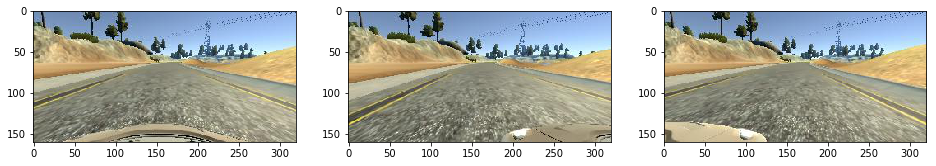

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

unshuffled = generator(path, train_samples, batch_size=128, shuffle=False)
sample_images, _ = next(unshuffled)

# Left | Center | Right images
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2,3]:
    fig.add_subplot(1,3,image_nb)
    sample_image = sample_images[2*(image_nb-1)]
    plt.imshow(sample_image)

plt.savefig('left-center-right_samples.png')

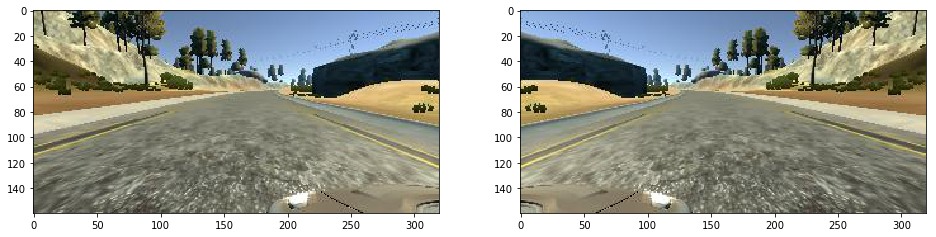

In [7]:
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2]:
    fig.add_subplot(1,2,image_nb)
    sample_image = sample_images[151+image_nb]
    plt.imshow(sample_image)

plt.savefig('flipped_samples.png')

In [16]:
print("""-- Dataset information -- 
The dataset has {} training samples and {} validation samples. Each batch has {} images.
Each image has an original size of {}x{}x{} (color).""".format(len(train_samples)*6,\
                                                              len(validation_samples)*6,\
                                                              len(sample_images),\
                                                              sample_image.shape[0],\
                                                              sample_image.shape[1],\
                                                              sample_image.shape[2]))

-- Dataset information -- 
The dataset has 24798 training samples and 6204 validation samples. Each batch has 768 images.
Each image has an original size of 160x320x3 (color).


Model Architecture
---
This is where we define the convolutional neural network that learns how to drive autonomously. See `readme.md` for more explanations about this architecture.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.backend import tf

Using TensorFlow backend.


In [18]:
def resize_im(x):
    from keras.backend import tf
    return tf.image.resize_images(x, (80, 160))

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Lambda(resize_im))

# -- Convolutions
model.add(Convolution2D(16,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# -- Flattening
model.add(Flatten())

# -- Dense layers
model.add(Dense(1000, activation='relu'))
model.add(Dropout(p=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(p=0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(p=0.5))

# -- Output
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 90, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 80, 160, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 80, 160, 16)   448         lambda_2[0][0]                   
___________________________________________________________________________________________

Model Training
---
Below we train the model, print the training and validation error and finally save the model so that it can be used by the driving script.

In [20]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch = len(train_samples)*6, 
                                     validation_data = validation_generator,    
                                     nb_val_samples = len(validation_samples)*6,     
                                     nb_epoch=5, 
                                     verbose=1)

model.save('model.h5')

Epoch 1/5
24768/24798 [============================>.] - ETA: 0s - loss: 0.0444

KeyboardInterrupt: 

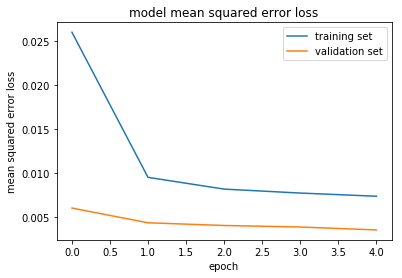

In [77]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [81]:
metrics_train = model.evaluate_generator(train_generator,val_samples=5000)
metrics_valid = model.evaluate_generator(validation_generator,val_samples=5000)

In [85]:
metrics_valid

0.0027860864410521806

In [83]:
metrics_train

0.0030436030097512733

In [ ]:
import os
import csv
import cv2
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D
import sklearn
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam



from sklearn.model_selection import train_test_split


def rgb2yuv(image):
    """
        Convert the image from RGB to YUV (This is what the NVIDIA model does)
        """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def add_random_shadow(image):
    top_y = image.shape[1]*np.random.uniform()
    top_x = 0
    bot_x = image.shape[0]
    bot_y = image.shape[1]*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    random_bright = .15+.8*np.random.uniform()
    if np.random.randint(2)==1:
        #    random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def preprocess(image):
    """
        Combine all preprocess functions into one
        """
   # image = rgb2yuv(image)
    image = random_brightness(image)
    #image = add_random_shadow(image)
    
    return image


def get_driving_log(path):
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines

del_angle = 0.001
del_rate = 0.5

def generator(path, samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_nb in [0, 1, 2]:
                    name = path + 'IMG/'+ batch_sample[image_nb].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    image = preprocess(image)
                    shift_dict = {0: 0, 1: 0.3, 2: -0.3}
                    angle = float(batch_sample[3]) + shift_dict.get(image_nb, "error")
                    if angle < del_angle: # to ignore zero steering angle data
                        if np.random.random() < del_rate:
                            continue

                    images.append(np.fliplr(image))
                    angles.append(-angle)
                
                    images.append(image)
                    angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

# ------ Training/Validation data loading -------

path = './data_Udacity_1/'

samples = get_driving_log(path)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

row, col, ch =160, 320, 3  # Trimmed image format
BATCH_SIZE = 32

def resize_im(x):
    from keras.backend import tf
    return tf.image.resize_images(x, (80, 160))

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Lambda(resize_im))

model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only='true' , mode='auto')

model.compile(loss='mse', optimizer='adam')


model.fit_generator(train_generator, samples_per_epoch = 20000, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[checkpoint], verbose=1)
model.save('model.h5')

# Explicitly end tensorflow session
from keras import backend as K
    
K.clear_session()

In [14]:
import os
import csv
import cv2
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D
import sklearn
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam



from sklearn.model_selection import train_test_split


def rgb2yuv(image):
    """
        Convert the image from RGB to YUV (This is what the NVIDIA model does)
        """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def add_random_shadow(image):
    top_y = image.shape[1]*np.random.uniform()
    top_x = 0
    bot_x = image.shape[0]
    bot_y = image.shape[1]*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    random_bright = .15+.8*np.random.uniform()
    if np.random.randint(2)==1:
        #    random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def preprocess(image):
    """
        Combine all preprocess functions into one
        """
    #image = rgb2yuv(image)
    image = random_brightness(image)
    #image = add_random_shadow(image)
    
    return image


def get_driving_log(path):
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines

In [15]:
del_angle = 0.001
del_rate = 0.5

def generator(path, samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_nb in [0, 1, 2]:
                    name = path + 'IMG/'+ batch_sample[image_nb].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    image = preprocess(image)
                    shift_dict = {0: 0, 1: 0.3, 2: -0.3}
                    angle = float(batch_sample[3]) + shift_dict.get(image_nb, "error")
                    if angle < del_angle: # to ignore zero steering angle data
                        if np.random.random() < del_rate:
                            continue

                    images.append(np.fliplr(image))
                    angles.append(-angle)
                
                    images.append(image)
                    angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [16]:
path = './data/'

samples = get_driving_log(path)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

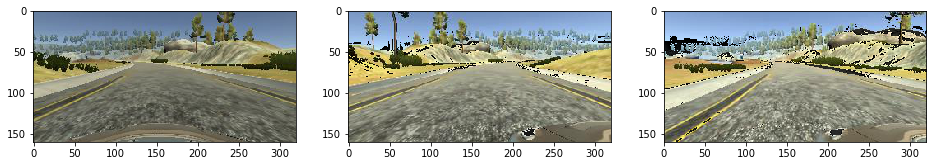

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

unshuffled = generator(path, train_samples, batch_size=128)
sample_images, _ = next(unshuffled)

# Left | Center | Right images
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2,3]:
    fig.add_subplot(1,3,image_nb)
    sample_image = sample_images[2*(image_nb-1)]
    plt.imshow(sample_image)

plt.savefig('left-center-right_samples.png')

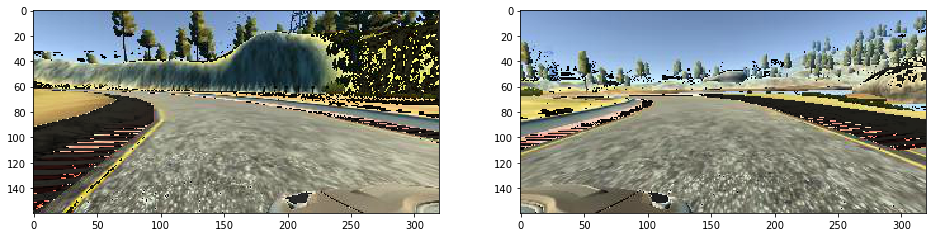

In [18]:
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2]:
    fig.add_subplot(1,2,image_nb)
    sample_image = sample_images[151+image_nb]
    plt.imshow(sample_image)

plt.savefig('flipped_samples.png')

In [12]:
print("""-- Dataset information -- 
The dataset has {} training samples and {} validation samples. Each batch has {} images.
Each image has an original size of {}x{}x{} (color).""".format(len(train_samples)*6,\
                                                              len(validation_samples)*6,\
                                                              len(sample_images),\
                                                              sample_image.shape[0],\
                                                              sample_image.shape[1],\
                                                              sample_image.shape[2]))

-- Dataset information -- 
The dataset has 9294 training samples and 2328 validation samples. Each batch has 504 images.
Each image has an original size of 160x320x3 (color).


In [13]:
# ------ Training/Validation data loading -------

path = './data_Udacity_1/'

samples = get_driving_log(path)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

row, col, ch =160, 320, 3  # Trimmed image format
BATCH_SIZE = 32

def resize_im(x):
    from keras.backend import tf
    return tf.image.resize_images(x, (80, 160))

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Lambda(resize_im))

model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only='true' , mode='auto')

model.compile(loss='mse', optimizer='adam')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 90, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 80, 160, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 78, 24)    1824        lambda_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
model.fit_generator(train_generator, samples_per_epoch = 20000, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[checkpoint], verbose=1)
model.save('model.h5')

# Explicitly end tensorflow session
from keras import backend as K
    
K.clear_session()